<a href="https://colab.research.google.com/github/jorobledo/blcourse_test/blob/main/BLcourse2/colab/Lecture2_comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Laplace approximation

The dataset we dealing with here contains several variables such as light, temperature, humidity, and CO2 levels. The goal is to detect a room’s occupancy from these variables. It is a binary variable and hence we are solving a classification problem.



In [1]:
!git clone https://github.com/jorobledo/blcourse_test.git
%cd blcourse_test/BLcourse2/colab/

Cloning into 'blcourse_test'...
remote: Enumerating objects: 506, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 506 (delta 0), reused 0 (delta 0), pack-reused 502 (from 1)
Receiving objects: 100% (506/506), 92.16 MiB | 7.84 MiB/s, done.
Resolving deltas: 100% (125/125), done.
Updating files: 100% (43/43), done.
/content/blcourse_test/BLcourse2/colab


In [2]:
#!pip install pymc
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np

df=pd.read_csv('../data/occupancy_data/datatest.txt')
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


### Creating a model with pymc

We create a model by specifying broad priors on the available variables (you can play around with what kind of priors you want to use and which variables to include). We also measure the time required to perform the computation.

PyMC provides a function that will approximate, if not find, the MAP location. In the PyMC main namespace is the `find_MAP` function. If you call it within the context of `Model()` there are all sorts of things one can do with it.

In [3]:
from pymc.distributions.dist_math import sigma2rho
import time
t0=time.perf_counter()
lower=-10**3
higher=10**3

with pm.Model() as first_model:

#     priors on parameters (uniform)

#     beta_0=pm.Uniform('beta_0', lower=lower, upper= higher)
#     beta_temp=pm.Uniform('beta_temp', lower, higher)
#     beta_humid=pm.Uniform('beta_humid', lower, higher)
#     beta_light=pm.Uniform('beta_light', lower, higher)
#     beta_co2=pm.Uniform('beta_co2', lower, higher)
#     beta_humid_ratio=pm.Uniform('beta_humid_ration', lower, higher)

#     priors on the parameters (normal)

    beta_0=pm.Normal('beta_0', 0, sigma=100)
    #beta_temp=pm.Normal('beta_temp', 0, sigma=100)
    #beta_humid=pm.Normal('beta_humid', 0, sigma=100)
    beta_light=pm.Normal('beta_light', 0, sigma=100)
    beta_co2=pm.Normal('beta_co2', 0, sigma=100)
    beta_humid_ratio=pm.Normal('beta_humid_ration', 0, sigma=100)

#     the probability of belonging to class 1 (likelihood)

    likelihood=pm.invlogit(beta_0+
                            #beta_temp*df['Temperature']+
                               #beta_humid*df['Humidity']+
                               beta_light*df['Light']+
                               beta_co2*df['CO2']+
                               beta_humid_ratio*df['HumidityRatio'])

with first_model:
    #fit the data

    observed=pm.Bernoulli("occupancy", likelihood, observed=df['Occupancy'])

    start=pm.find_MAP()

t1=time.perf_counter()
t1-t0

Output()

41.86982698599999

Now we need to find Hessian. We pass the MAP point as a point where we want to compute the Hessian.

In [4]:
t0=time.perf_counter()
with first_model:
    hes=pm.find_hessian(point=start)

t1=time.perf_counter()
t1-t0

/usr/local/lib/python3.11/dist-packages/pytensor/configparser.py:44: FutureWarning: hessian will stop negating the output in a future version of PyMC.
To suppress this warning set `negate_output=False`
  return f(*args, **kwargs)


44.069801487999996

We can now see how long it took to provide an estimate to the posterior distribution. Later we will compare the timings between MCMC and Laplace approximation.

In [5]:
#pass the MAP estimates to the vector of expectation

start1=np.array([start['beta_0'],start['beta_light'],start['beta_co2'],start['beta_humid_ration']])

#sample from the multivariable normal distribution thereby creating a normal approximation of our variables

y=pm.MvNormal.dist(mu=start1,tau=hes,shape=4)

Now let us plot the distribution (histograms) of the parameters and compare them with the above plots obtained from the MCMC

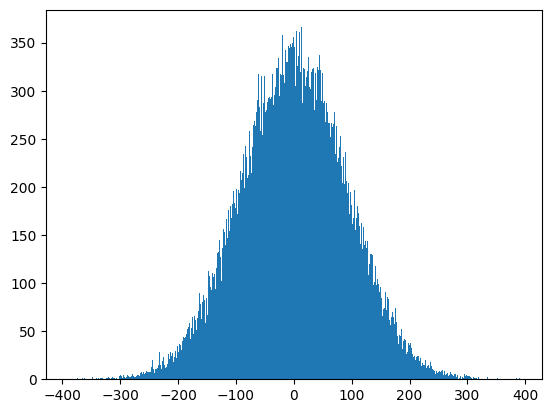

In [6]:
beta_humid_ration_post=plt.hist(pm.draw(y,draws=100000)[:,3],bins=1000)

Plot posterior distributions of the parameters (left) and visualise the Markov chains themselves (right)

## MCMC

======
`Original content created by Cam Davidson-Pilon`

`Ported to Python 3 and PyMC3 by Max Margenot (@clean_utensils) and Thomas Wiecki (@twiecki) at Quantopian (@quantopian)`



When we are talking about efficiently moving around the posterior space, what do we actually mean?

When we setup a Bayesian inference problem with $N$ unknowns, we are implicitly creating an $N$ dimensional space for the prior distributions to exist in. Associated with the space is an additional dimension, which we can describe as the *surface*, or *curve*, that sits on top of the space, that reflects the *prior probability* of a particular point. The surface on the space is defined by our prior distributions. For example, if we have two unknowns $p_1$ and $p_2$, and priors for both are $\text{Uniform}(0,5)$, the space created is a square of length 5 and the surface is a flat plane that sits on top of the square (representing that every point is equally likely).

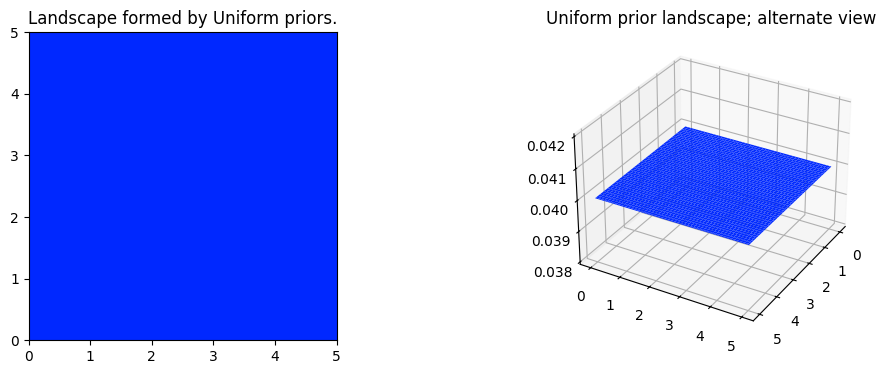

In [7]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Uniform prior landscape; alternate view");



Alternatively, if the two priors are $\text{Exp}(3)$ and $\text{Exp}(10)$, then the space is all positive numbers on the 2-D plane, and the surface induced by the priors looks like a water fall that starts at the point (0,0) and flows over the positive numbers.

The plots below visualize this. The more dark red the color, the more prior probability is assigned to that location. Conversely, areas with darker blue represent that our priors assign very low probability to that location.

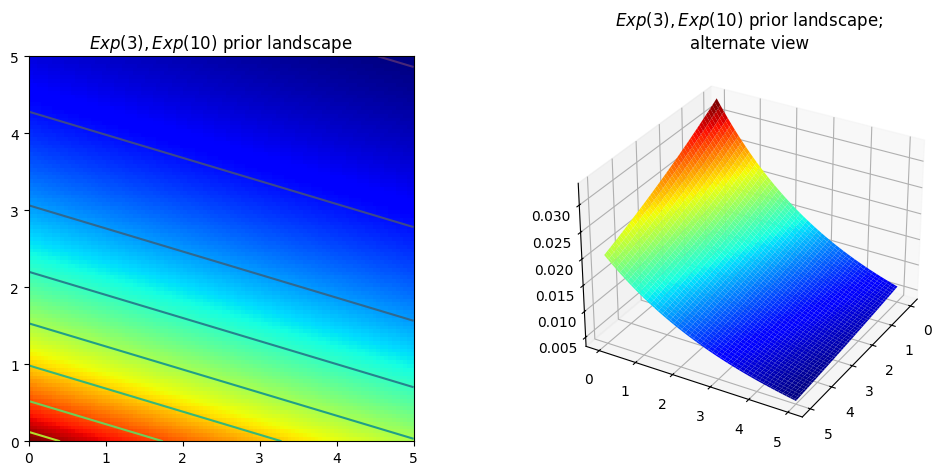

In [8]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
#plt.xlabel("prior on $p_1$")
#plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view");



These are simple examples in 2D space, where our brains can understand surfaces well. In practice, spaces and surfaces generated by our priors can be much higher dimensional.

If these surfaces describe our *prior distributions* on the unknowns, what happens to our space after we incorporate our observed data $X$? The data $X$ does not change the space, but it changes the surface of the space by *pulling and stretching the fabric of the prior surface* to reflect where the true parameters likely live. More data means more pulling and stretching, and our original shape becomes mangled or insignificant compared to the newly formed shape. Less data, and our original shape is more present.  Regardless, the resulting surface describes the *posterior distribution*.

Again I must stress that it is, unfortunately, impossible to visualize this in large dimensions. For two dimensions, the data essentially *pushes up* the original surface to make *tall mountains*. The tendency of the observed data to *push up* the posterior probability in certain areas is checked by the prior probability distribution, so that less prior probability means more resistance. Thus in the double-exponential prior case above, a mountain (or multiple mountains) that might erupt near the (0,0) corner would be much higher than mountains that erupt closer to (5,5), since there is more resistance (low prior probability) near (5,5). The peak reflects the posterior probability of where the true parameters are likely to be found. Importantly, if the prior has assigned a probability of 0, then no posterior probability will be assigned there.

Suppose the priors mentioned above represent different parameters $\lambda$ of two Poisson distributions. We observe a few data points and visualize the new landscape:

In [9]:
# create the observed data

# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 1

# the true parameters, but of course we do not see these values...
lambda_1_true = 1
lambda_2_true = 3

#...we see the data generated, dependent on the above two values.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print("observed (2-dimensional,sample size = %d):" % N, data)

# plotting details.
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

observed (2-dimensional,sample size = 1): [[1 8]]


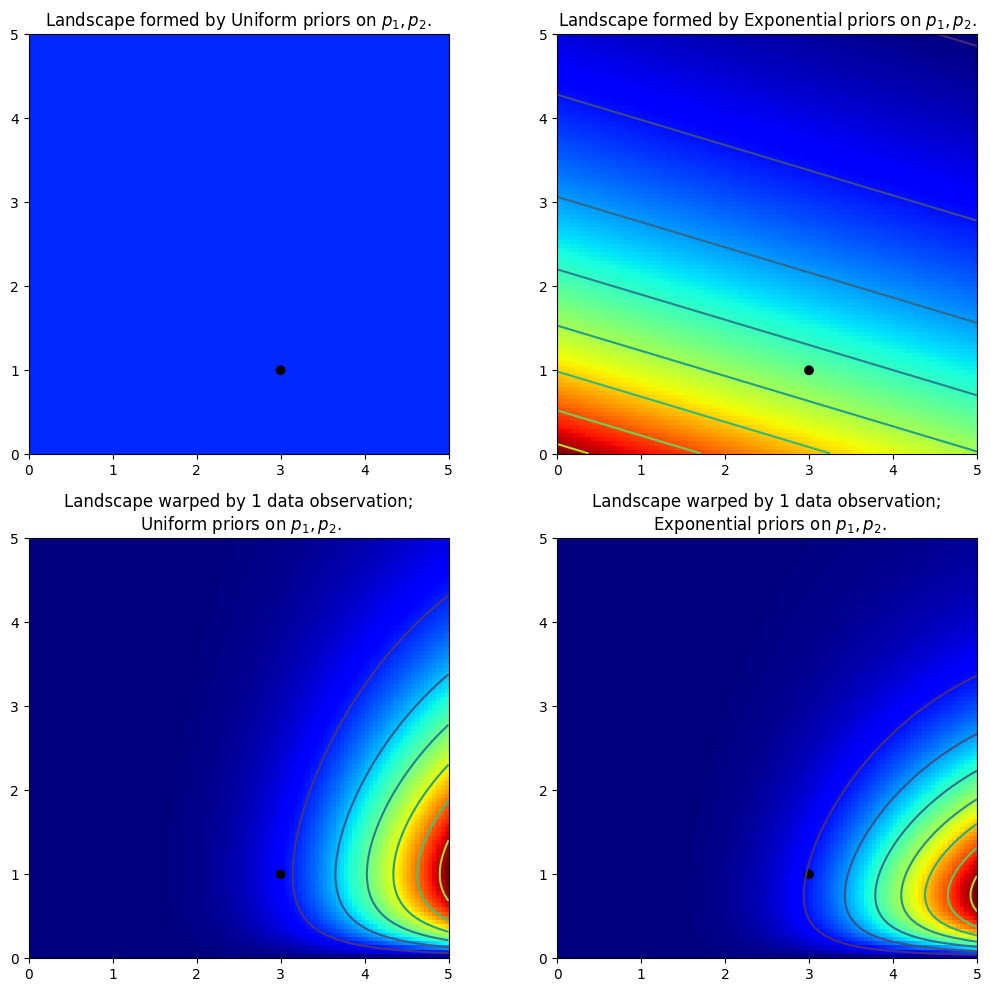

In [10]:
figsize(12.5, 12)
# matplotlib heavy lifting below, beware!
plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors on $p_1, p_2$.")

plt.subplot(223)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N)
plt.xlim(0, 5)
plt.ylim(0, 5);

The plot on the left is the deformed landscape with the $\text{Uniform}(0,5)$ priors, and the plot on the right is the deformed landscape with the exponential priors. Notice that the posterior landscapes look different from one another, though the data observed is identical in both cases. The reason is as follows. Notice the exponential-prior landscape, bottom right figure, puts very little *posterior* weight on values in the upper right corner of the figure: this is because *the prior does not put much weight there*. On the other hand, the uniform-prior landscape is happy to put posterior weight in the upper-right corner, as the prior puts more weight there.

Notice also the highest-point, corresponding the the darkest red, is biased towards (0,0) in the exponential case, which is the result from the exponential prior putting more prior weight in the (0,0) corner.

The black dot represents the true parameters. Even with 1 sample point, the mountains attempts to contain the true parameter. Of course, inference with a sample size of 1 is incredibly naive, and choosing such a small sample size was only illustrative.

It's a great exercise to try changing the sample size to other values (try 2,5,10,100?...) and observing how our "mountain" posterior changes.

The plot on the left is the deformed landscape with the $\text{Uniform}(0,5)$ priors, and the plot on the right is the deformed landscape with the exponential priors. Notice that the posterior landscapes look different from one another, though the data observed is identical in both cases. The reason is as follows. Notice the exponential-prior landscape, bottom right figure, puts very little *posterior* weight on values in the upper right corner of the figure: this is because *the prior does not put much weight there*. On the other hand, the uniform-prior landscape is happy to put posterior weight in the upper-right corner, as the prior puts more weight there.

Notice also the highest-point, corresponding to the darkest red, is biased towards (0,0) in the exponential case, which is the result from the exponential prior putting more prior weight in the (0,0) corner.

The black dot represents the true parameters. Even with 1 sample point, the mountains attempts to contain the true parameter. Of course, inference with a sample size of 1 is incredibly naive, and choosing such a small sample size was only illustrative.

It's a great exercise to try changing the sample size to other values (try 2,5,10,100?...) and observing how our "mountain" posterior changes.

### Algorithms to perform MCMC

There is a large family of algorithms that perform MCMC. Most of these algorithms can be expressed at a high level as follows:

1. Start at current position.
2. Propose moving to a new position .
3. Accept/Reject the new position based on the position's adherence to the data and prior distributions.
4.  1.  If you accept: Move to the new position. Return to Step 1.
    2. Else: Do not move to new position. Return to Step 1.
5. After a large number of iterations, return all accepted positions.

This way we move in the general direction towards the regions where the posterior distributions exist, and collect samples sparingly on the journey. Once we reach the posterior distribution, we can easily collect samples as they likely all belong to the posterior distribution.

If the current position of the MCMC algorithm is in an area of extremely low probability, which is often the case when the algorithm begins (typically at a random location in the space), the algorithm will move in positions *that are likely not from the posterior* but better than everything else nearby. Thus the first moves of the algorithm are not reflective of the posterior.

In the above algorithm's pseudocode, notice that only the current position matters (new positions are investigated only near the current position). We can describe this property as *memorylessness*, this is the key property of a Markov chain, i.e. the algorithm does not care *how* it arrived at its current position, only that it is there.


##### Example: Unsupervised Clustering using a Mixture Model


Suppose we are given the following dataset:



[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


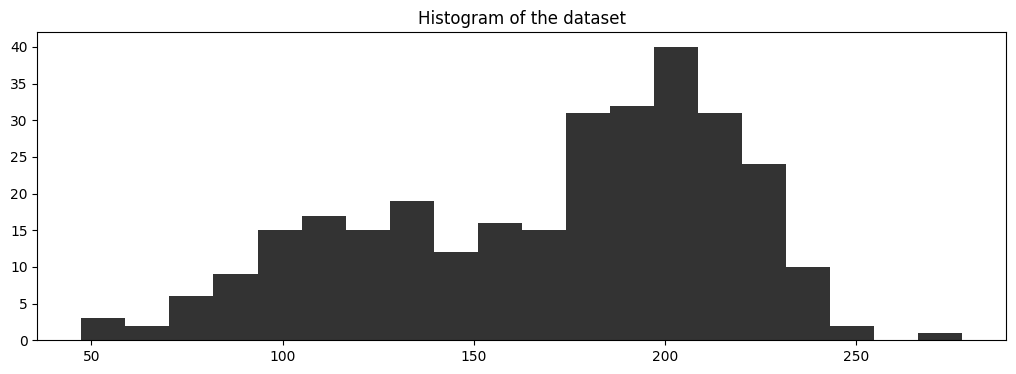

In [12]:
figsize(12.5, 4)
data = np.loadtxt("../data/mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data[:10], "...")



What does the data suggest? It appears the data has a bimodal form, that is, it appears to have two peaks, one near 120 and the other near 200. Perhaps there are *two clusters* within this dataset.

This dataset is a good example of the data-generation modeling technique from last chapter. We can propose *how* the data might have been created. I suggest the following data generation algorithm:

1. For each data point, choose cluster 1 with probability $p$, else choose cluster 2.
2. Draw a random variate from a Normal distribution with parameters $\mu_i$ and $\sigma_i$ where $i$ was chosen in step 1.
3. Repeat.

This algorithm would create a similar effect as the observed dataset, so we choose this as our model. Of course, we do not know $p$ or the parameters of the Normal distributions. Hence we must infer, or *learn*, these unknowns.

Denote the Normal distributions $\text{N}_0$ and $\text{N}_1$ (having variables' index start at 0 is just Pythonic). Both currently have unknown mean and standard deviation, denoted $\mu_i$ and $\sigma_i, \; i =0,1$ respectively. A specific data point can be from either $\text{N}_0$ or $\text{N}_1$, and we assume that the data point is assigned to $\text{N}_0$ with probability $p$.


An appropriate way to assign data points to clusters is to use a PyMC `Categorical` stochastic variable. Its parameter is a $k$-length array of probabilities that must sum to one and its `value` attribute is a integer between 0 and $k-1$ randomly chosen according to the crafted array of probabilities (In our case $k=2$). *A priori*, we do not know what the probability of assignment to cluster 1 is, so we form a uniform variable on $(0, 1)$. We call call this $p_1$, so the probability of belonging to cluster 2 is therefore $p_2 = 1 - p_1$.

Unfortunately, we can't we just give `[p1, p2]` to our `Categorical` variable. PyMC uses PyTensor under the hood to construct the models so we need to use `pytensor.tensor.stack()` to combine $p_1$ and $p_2$ into a vector that it can understand. We pass this vector into the `Categorical` variable as well as the `testval` parameter to give our variable an idea of where to start from.

In [14]:
import pymc as pm
import pytensor.tensor as pt
import pytensor


with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = pt.stack([p1, p2])
    assignment = pm.Categorical("assignment", p,
                                shape=data.shape[0],
                                initval=np.random.randint(0, 2, data.shape[0]))


print(f"prior assignment, with p = {pm.draw(p)}")

prior assignment, with p = [0.77196655 0.22803345]


Looking at the above dataset, I would guess that the standard deviations of the two Normals are different. To maintain ignorance of what the standard deviations might be, we will initially model them as uniform on 0 to 100. We will include both standard deviations in our model using a single line of PyMC code:

    sds = pm.Uniform("sds", 0, 100, shape=2)

Notice that we specified `shape=2`: we are modeling both $\sigma$s as a single PyMC variable. Note that this does not induce a necessary relationship between the two $\sigma$s, it is simply for succinctness.

We also need to specify priors on the centers of the clusters. The centers are really the $\mu$ parameters in these Normal distributions. Their priors can be modeled by a Normal distribution. Looking at the data, I have an idea where the two centers might be &mdash; I would guess somewhere around 120 and 190 respectively, though I am not very confident in these eyeballed estimates. Hence I will set $\mu_0 = 120, \mu_1 = 190$ and $\sigma_0 = \sigma_1 = 10$.

In [15]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)
    # form new API, may use the sigma/tau for paramter tau = 1/(sigma**2),
    # the sd is not supported anymore in Normal
    # https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Normal.html
    centers = pm.Normal("centers",
                        mu=np.array([120, 190]),
                        sigma=np.array([10., 10.]),
                        shape=2)

    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])

    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=center_i, sigma=sd_i, observed=data)

print("Random assignments: ", pm.draw(assignment)[:4], "...")
print("Assigned center: ", pm.draw(center_i)[:4], "...")
print("Assigned standard deviation: ", pm.draw(sd_i)[:4],"...")

Random assignments:  [1 1 1 1] ...
Assigned center:  [182.08911581 182.08911581 116.59671756 182.08911581] ...
Assigned standard deviation:  [23.3710944  23.3710944  47.19150004 47.19150004] ...


Notice how we continue to build the model within the context of `Model()`. This automatically adds the variables that we create to our model. As long as we work within this context we will be working with the same variables that we have already defined.

Similarly, any sampling that we do within the context of `Model()` will be done only on the model whose context in which we are working. We will tell our model to explore the space that we have so far defined by defining the sampling methods, in this case `Metropolis()` for our continuous variables and `Categorical()` for our categorical variable. We will use these sampling methods together to explore the space by using `sample( iterations, step )`, where `iterations` is the number of steps you wish the algorithm to perform and `step` is the way in which you want to handle those steps. We use our combination of `Metropolis()` and `Categorical()` for the `step` and sample 25000 `iterations` below.

Note that `Metropolis()` allows us to specify the distribution of the proposal using `proposal_dist` variable. The default value is Normally distributed, but for list of available proposal distributions please check out https://github.com/pymc-devs/pymc/blob/main/pymc/step_methods/metropolis.py .

If one has very special prior knowledge on the shape of posterior space there is also a possibility of creating a custom proposal via writing a corresponding class.

Variable `tune` is set to True by default and allows to tune the width of the proposal distribution during burn-in by ensuring a reasonable acceptance rate. You can also pass an integer to `tune` in order to specify the exact number of iterations you want to tune your proposal.

Please notice that the early version of PyMC use `ElemwiseCategorical()` for

---

categorical variable. But in PyMC, it was deprecated. But new PyMC provieds a new functions to do the categorical sampling, the `CategoricalGibbsMetropolis` optimized for categorical variables.

There are another interesting thing with new PyMC. The PyMC use a powerful new sampling principle be called Hamiltonian Monte Carlo (HMC). We'll not talk too much about it here, since it's a complex physical principle. But we should know that [HMC and NUTS take advantage of gradient information from the likelihood to achieve much faster convergence than traditional sampling methods, especially for larger models. ](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#pymc-overview)



Please also notice the parameter `chains` of `sample()`. According to the API document, `"Running independent chains is important for some convergence statistics and can also reveal multiple modes in the posterior."`. But it's unnecessary here, our model is simple enough and we use `1` here (the default value is 2)

In [23]:
pytensor.config.compute_test_value = 'off'
with model:
    # We use the CategoricalGibbsMetropolis, and return_inferencedata=False here for compatibility.
    step1 = pm.NUTS(vars=[p1, sds, centers])
    step2 = pm.CategoricalGibbsMetropolis(vars=[assignment])
    trace1 = pm.sample(25000, step=[step1, step2],return_inferencedata=False,tune=5000,chains=1)

    # Use the default NUTS for sampling, and we return the Arviz InferenceData
    step3 = pm.CategoricalGibbsMetropolis(vars=[assignment])
    trace2 = pm.sample(25000, step=[step3],tune=5000,chains=1)

Output()

Output()

We have stored the paths of all our variables, or "traces", in the `trace` variable. These paths are the routes the unknown parameters (centers, precisions, and $p$) have taken thus far. The individual path of each variable is indexed by the PyMC3 variable `name` that we gave that variable when defining it within our model. For example, `trace["sds"]` will return a `numpy array` object that we can then index and slice as we would any other `numpy array` object.


In [24]:
print(trace1.varnames) #print the variables we traced

accept = np.sum(trace1['p'][1:] != trace1['p'][:-1]) #what is overall acceptance rate?
print(accept/trace1['p'].shape[0]) #print the overall acceptance rate


['p_interval__', 'assignment', 'sds_interval__', 'centers', 'p', 'sds', 'center_i', 'sd_i']
0.94544


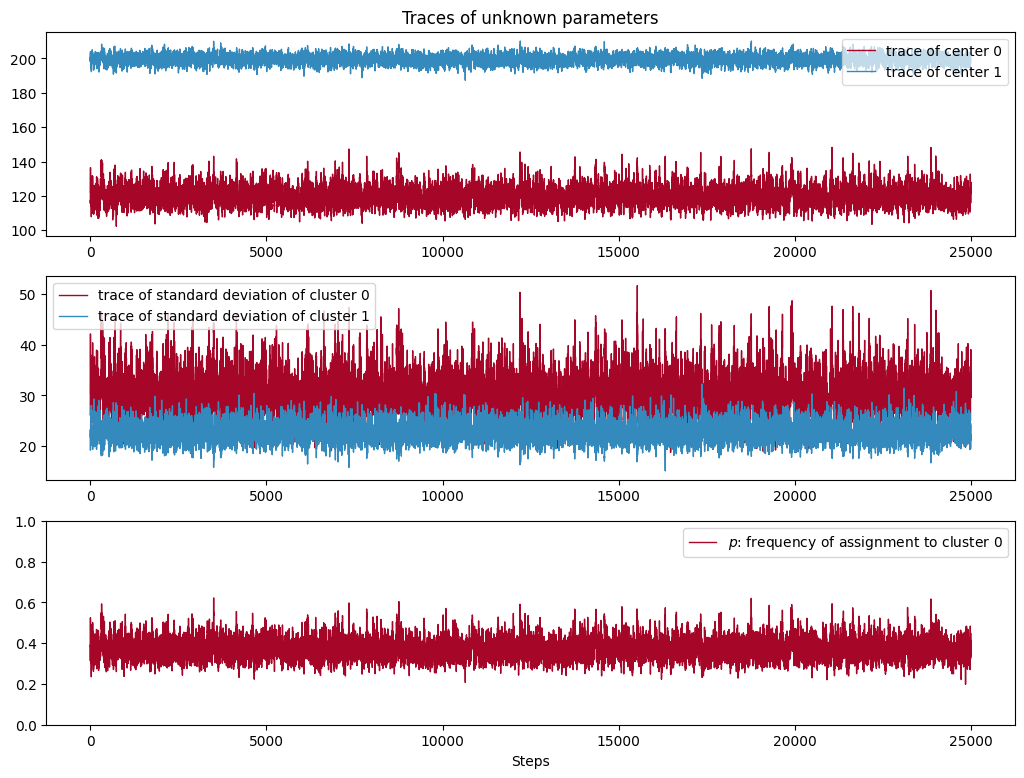

In [25]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = trace1["centers"]

# for pretty colors later in the book.
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace1["sds"]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace1["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();

Notice the following characteristics:

1. The traces converges, not to a single point, but to a *distribution* of possible points, i.e. *stationary distribution*. This is *convergence* in an MCMC algorithm.
2. Inference using the first few thousand points is a bad idea, as they are unrelated to the final distribution we are interested in. Thus it is a good idea to discard those samples before using the samples for inference. We call this period before converge the *burn-in period*.
3. The traces appear as a random "walk" around the space, that is, the paths exhibit correlation with previous positions. This is both good and bad. We will always have correlation between current positions and the previous positions, but too much of it means we are not exploring the space well. This will be detailed in the Diagnostics section  later in this chapter.


To achieve further convergence, we will perform more MCMC steps. In the pseudo-code algorithm of MCMC above, the only position that matters is the current position (new positions are investigated near the current position), implicitly stored as part of the `trace` object. To continue where we left off, we pass the `trace` that we have already stored into the `sample()` function with the same step value. The values that we have already calculated will not be overwritten. This ensures that our sampling continues where it left off in the same way that it left off.

We will sample the MCMC fifty thousand more times and visualize the progress below:

In [26]:
with model:
    trace3 = pm.sample(25000, step=[step3],tune=5000,chains=2)

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


<ipython-input-30-59dee4dd351c>:4: FutureWarning: extract_dataset has been deprecated, please use extract
  sample_data=az.extract_dataset(trace3)


(2, 60000)
(2, 35000)


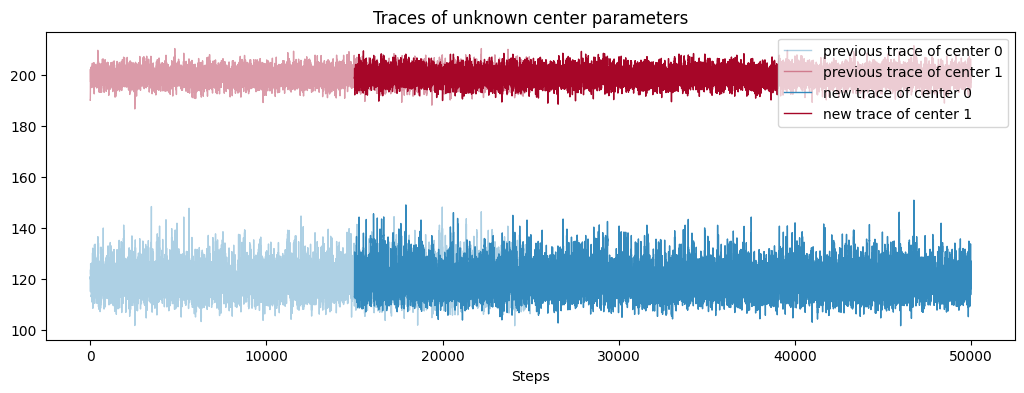

In [30]:
#!pip install arviz
import arviz as az
figsize(12.5, 4)
sample_data=az.extract_dataset(trace3)
print(sample_data.centers.data.shape)
center_trace_after_25000 = sample_data.centers.data[:,25000:]
center_trace_before25000 = sample_data.centers.data[:,:25000]
print(center_trace_after_25000.shape)

x = np.arange(25000)
plt.plot(x, center_trace_before25000[0,:], label="previous trace of center 0",
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, center_trace_before25000[1,:], label="previous trace of center 1",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(15000, 50000)
plt.plot(x, center_trace_after_25000[0,: ], label="new trace of center 0", lw=lw, c="#348ABD")
plt.plot(x, center_trace_after_25000[1,: ], label="new trace of center 1", lw=lw, c="#A60628")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");



#### Cluster Investigation

We have not forgotten our main challenge: identify the clusters. We have determined posterior distributions for our unknowns. We plot the posterior distributions of the center and standard deviation variables below:

<ipython-input-31-12b8f6aa3720>:2: FutureWarning: extract_dataset has been deprecated, please use extract
  sample_data=az.extract_dataset(trace3)


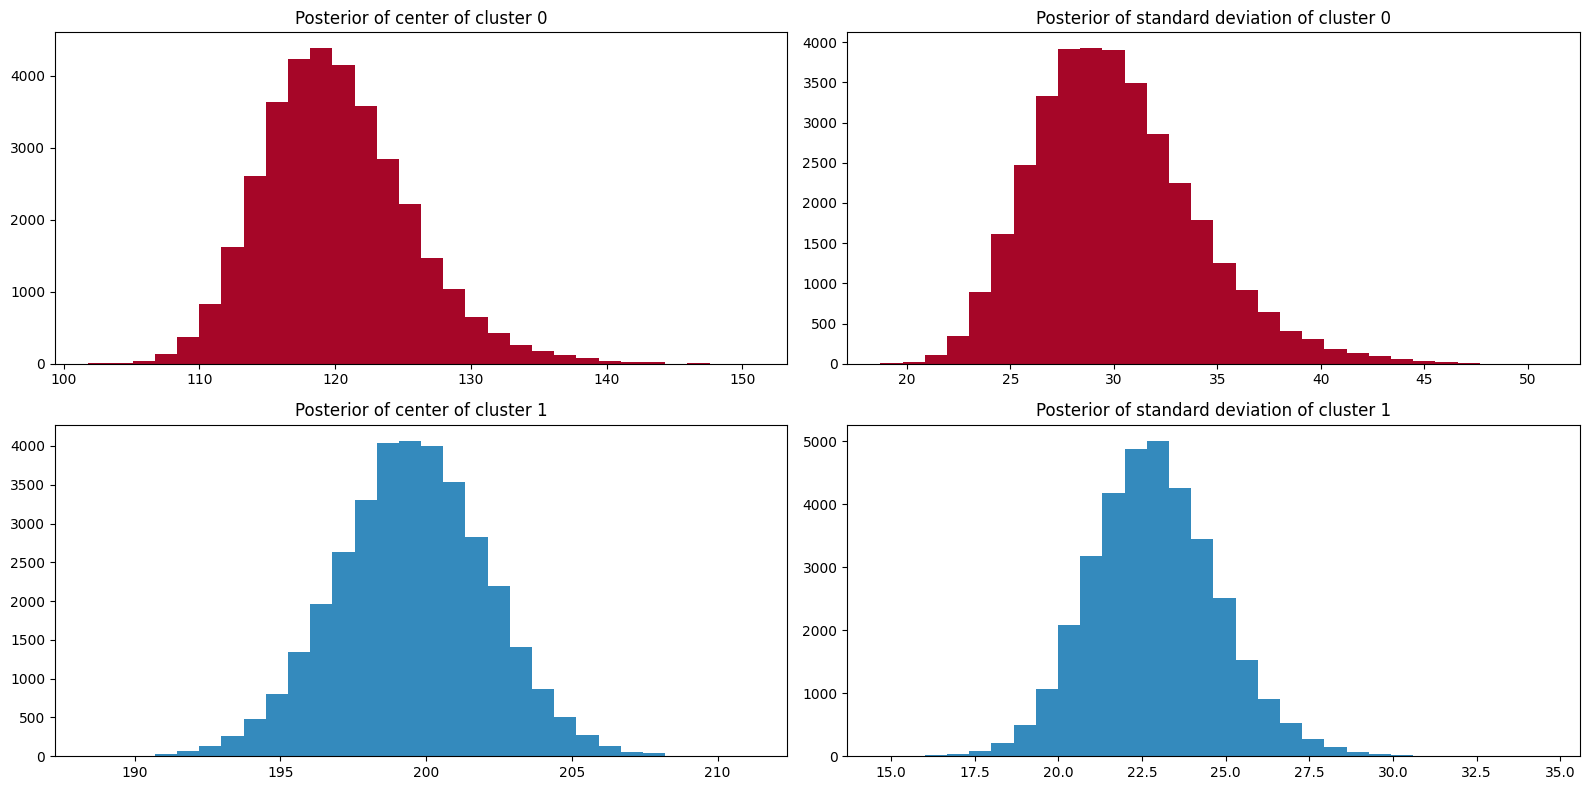

In [31]:
figsize(16.0, 8)
sample_data=az.extract_dataset(trace3)
std_trace_after25000 =  sample_data.sds.data[:,25000:]
std_trace_before25000 = sample_data.sds.data[:,:25000]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace_after_25000[i,:], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace_after25000[i,:], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()


The MCMC algorithm has proposed that the most likely centers of the two clusters are near 120 and 200 respectively. Similar inference can be applied to the standard deviation.

We are also given the posterior distributions for the labels of the data point, which is present in `trace["assignment"]`. Below is a visualization of this. The y-axis represents a subsample of the posterior labels for each data point. The x-axis are the sorted values of the data points. A red square is an assignment to cluster 1, and a blue square is an assignment to cluster 0.

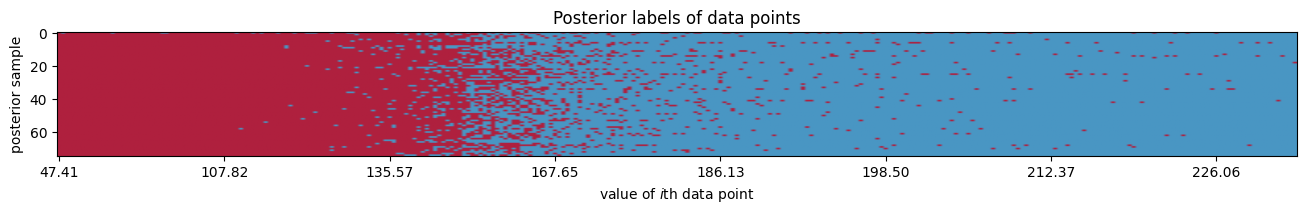

In [32]:
import matplotlib as mpl
figsize(16, 4)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(sample_data.assignment.data.T[::800, np.argsort(data)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");

Looking at the above plot, it appears that the most uncertainty is between 150 and 170. The above plot slightly misrepresents things, as the x-axis is not a true scale (it displays the value of the $i$th sorted data point.) A more clear diagram is below, where we have estimated the *frequency* of each data point belonging to the labels 0 and 1.

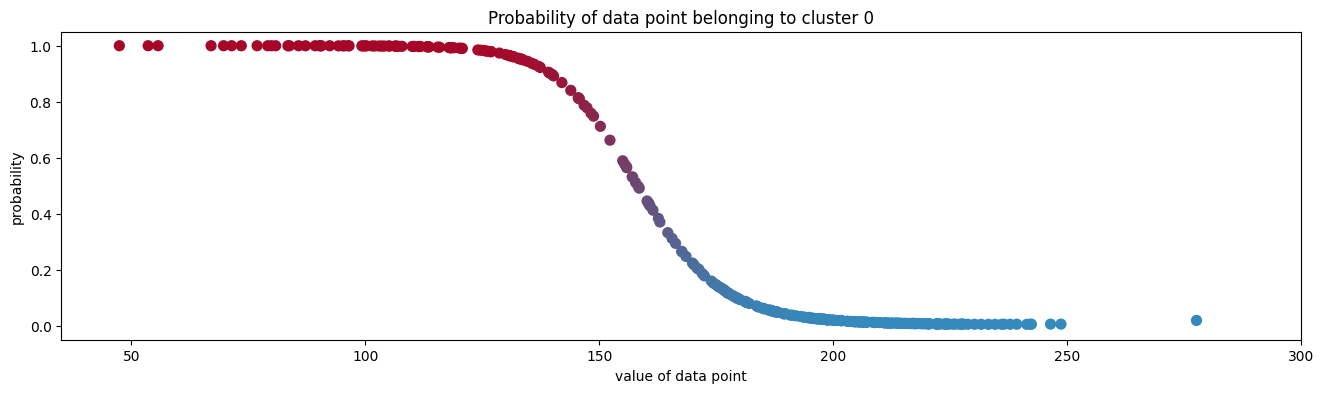

In [33]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = sample_data.assignment.data.T
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point");

Even though we modeled the clusters using Normal distributions, we didn't get just a single Normal distribution that *best* fits the data (whatever our definition of best is), but a distribution of values for the Normal's parameters. How can we choose just a single pair of values for the mean and variance and determine a *sorta-best-fit* gaussian?

One quick and dirty way, is to use the *mean* of the posterior distributions. Below we overlay the Normal density functions, using the mean of the posterior distributions as the chosen parameters, with our observed data:

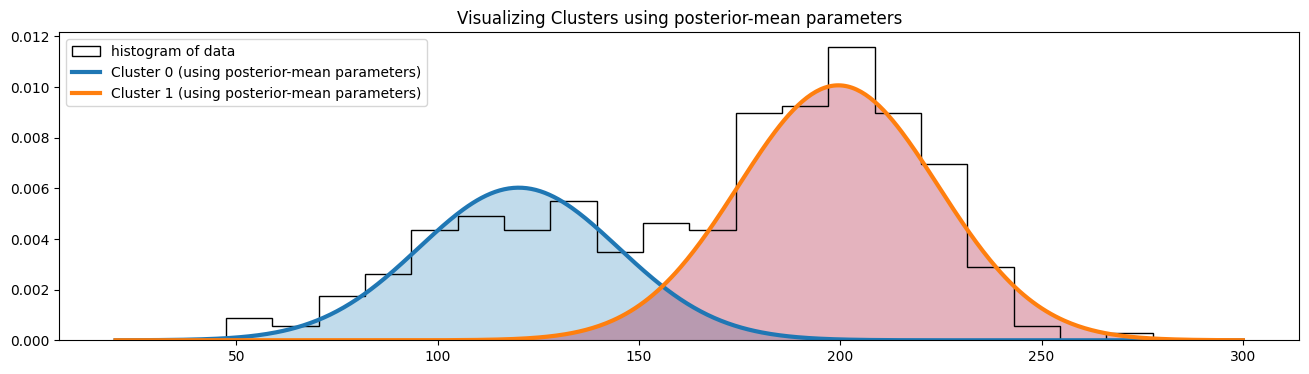

In [34]:
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace_after_25000.T.mean(axis=0)
posterior_std_means = std_trace_after25000.mean(axis=0)
posterior_p_mean = sample_data.p.data.mean()

plt.hist(data, bins=20, histtype="step", density=True, color="k",
     lw=2, label="histogram of data")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");

#### Prediction
The above clustering can be generalized to $k$ clusters. Choosing $k=2$ allowed us to visualize the MCMC better, and examine some very interesting plots.

What about prediction? Suppose we observe a new data point, say $x = 175$, and we wish to label it to a cluster. It is foolish to simply assign it to the *closer* cluster center, as this ignores the standard deviation of the clusters, and we have seen from the plots above that this consideration is very important. More formally: we are interested in the *probability* (as we cannot be certain about labels) of assigning $x=175$ to cluster 1. Denote the assignment of $x$ as $L_x$, which is equal to 0 or 1, and we are interested in $P(L_x = 1 \;|\; x = 175 )$.  

A naive method to compute this is to re-run the above MCMC with the additional data point appended. The disadvantage with this method is that it will be slow to infer for each novel data point. Alternatively, we can try a *less precise*, but much quicker method.

We will use Bayes Theorem for this. If you recall, Bayes Theorem looks like:

$$ P( A | X ) = \frac{ P( X  | A )P(A) }{P(X) }$$

In our case, $A$ represents $L_x = 1$ and $X$ is the evidence we have: we observe that $x = 175$. For a particular sample set of parameters for our posterior distribution, $( \mu_0, \sigma_0, \mu_1, \sigma_1, p)$, we are interested in asking "Is the probability that $x$ is in cluster 1 *greater* than the probability it is in cluster 0?", where the probability is dependent on the chosen parameters.

\begin{align}
& P(L_x = 1| x = 175 ) \gt P(L_x = 0| x = 175 ) \\\\[5pt]
& \frac{ P( x=175  | L_x = 1  )P( L_x = 1 ) }{P(x = 175) } \gt \frac{ P( x=175  | L_x = 0  )P( L_x = 0 )}{P(x = 175) }
\end{align}

As the denominators are equal, they can be ignored (and good riddance, because computing the quantity $P(x = 175)$ can be difficult).

$$  P( x=175  | L_x = 1  )P( L_x = 1 ) \gt  P( x=175  | L_x = 0  )P( L_x = 0 ) $$




In [35]:
norm_pdf = stats.norm.pdf
p_trace = trace3.posterior.p.data[:,12500:]
prev_p_trace = trace3.posterior.p.data[:,:12500]
#update center_trace and std_trace from trace3
center_trace = trace3.posterior.centers.data[:, 12500:,:]
std_trace = trace3.posterior.sds.data[:, 12500:,:]
x = 175

v = p_trace[0,:] * norm_pdf(x, loc=center_trace[:, :,0], scale=std_trace[:,:,0]) > \
    (1 - p_trace) [0,:]* norm_pdf(x, loc=center_trace[:, :,1], scale=std_trace[:,:,1])

print("Probability of belonging to cluster 1:", v.mean())


Probability of belonging to cluster 1: 0.004571428571428572


Giving us a probability instead of a label is a very useful thing. Instead of the naive

    L = 1 if prob > 0.5 else 0

we can optimize our guesses using a *loss function*, which the entire fifth chapter is devoted to.  


### Using `MAP` to improve convergence

If you ran the above example yourself, you may have noticed that our results were not consistent: perhaps your cluster division was more scattered, or perhaps less scattered. The problem is that our traces are a function of the *starting values* of the MCMC algorithm.

It can be mathematically shown that letting the MCMC run long enough, by performing many steps, the algorithm *should forget its initial position*. In fact, this is what it means to say the MCMC converged (in practice though we can never achieve total convergence). Hence if we observe different posterior analysis, it is likely because our MCMC has not fully converged yet, and we should not use samples from it yet (we should use a larger burn-in period ).

In fact, poor starting values can prevent any convergence, or significantly slow it down. Ideally, we would like to have the chain start at the *peak* of our landscape, as this is exactly where the posterior distributions exist. Hence, if we started at the "peak", we could avoid a lengthy burn-in period and incorrect inference. Generally, we call this "peak" the *maximum a posterior* or, more simply, the *MAP*.

Of course, we do not know where the MAP is. PyMC provides a function that will approximate, if not find, the MAP location. In the PyMC main namespace is the `find_MAP` function. If you call this function within the context of `Model()`, it will calculate the MAP which you can then pass to `pm.sample()` as a `start` parameter.

    start = pm.find_MAP()
    trace = pm.sample(2000, step=pm.Metropolis, start=start)

The `find_MAP()` function has the flexibility of allowing the user to choose which optimization algorithm to use (after all, this is a optimization problem: we are looking for the values that maximize our landscape), as not all optimization algorithms are created equal. The default optimization algorithm in function call is the Broyden-Fletcher-Goldfarb-Shanno ([BFGS](https://en.wikipedia.org/wiki/Broyden-Fletcher-Goldfarb-Shanno_algorithm)) algorithm to find the maximum of the log-posterior. As an alternative, you can use other optimization algorithms from the `scipy.optimize` module. For example, you can use Powell's Method, a favourite of PyMC blogger [Abraham Flaxman](http://healthyalgorithms.com/) [1], by calling `find_MAP(fmin=scipy.optimize.fmin_powell)`. The default works well enough, but if convergence is slow or not guaranteed, feel free to experiment with Powell's method or the other algorithms available.

The MAP can also be used as a solution to the inference problem, as mathematically it  is the *most likely* value for the unknowns. But as mentioned earlier in this chapter,  this location ignores the uncertainty and doesn't return a distribution.

#### Speaking of the burn-in period

It is still a good idea to decide on a burn-in period, even if we are using `find_MAP()` prior to sampling, just to be safe. We can no longer automatically discard sample with a `burn` parameter in the `sample()` function as we could in PyMC2, in new PyMC (v4), it's change to the new paramter `tune` and `discard_tuned_samples`. It provides number of iterations to tune, defaults to 1000. Samplers adjust the step sizes, scalings or similar during tuning. Tuning samples will be drawn in addition to the number specified in the `draws` argument, and will be discarded unless `discard_tuned_samples` is set to `False`. The old `start` parameter also changed to `initvals`, and can now do more. The new code would look something like:

    with pm.Model() as model:
        start = pm.find_MAP()
        
        step = pm.Metropolis()
        trace = pm.sample(100000, step=step, initvals=start, tune=50000)
    

## Diagnosing Convergence

### Autocorrelation

Autocorrelation is a measure of how related a series of numbers is with itself. A measurement of 1.0 is perfect positive autocorrelation, 0 no autocorrelation, and -1 is perfect negative correlation.  If you are familiar with standard *correlation*, then autocorrelation is just how correlated a series, $x_t$, at time $t$ is with the series at time $t-k$

By the nature of the MCMC algorithm, we will always be returned samples that exhibit autocorrelation (this is because of the step `from your current position, move to a position near you`).

A chain that is not exploring the space well will exhibit very high autocorrelation. Visually, if the trace seems to meander like a river, and not settle down, the chain will have high autocorrelation.

This does not imply that a converged MCMC has low autocorrelation. Hence low autocorrelation is not necessary for convergence, but it is sufficient. PyMC3 has a built-in autocorrelation plotting function in the `plots` module.

PyMC3 outsources its statistics and diagnostics to the package `arviz`, which we are going to use to plot autocorrelations. However for that we need to convert our trace data into an arviz object. We can do it within the `model` context and subsequently use it for our needs.



array([<Axes: title={'center': 'x\n0'}>, <Axes: title={'center': 'x\n1'}>],
      dtype=object)

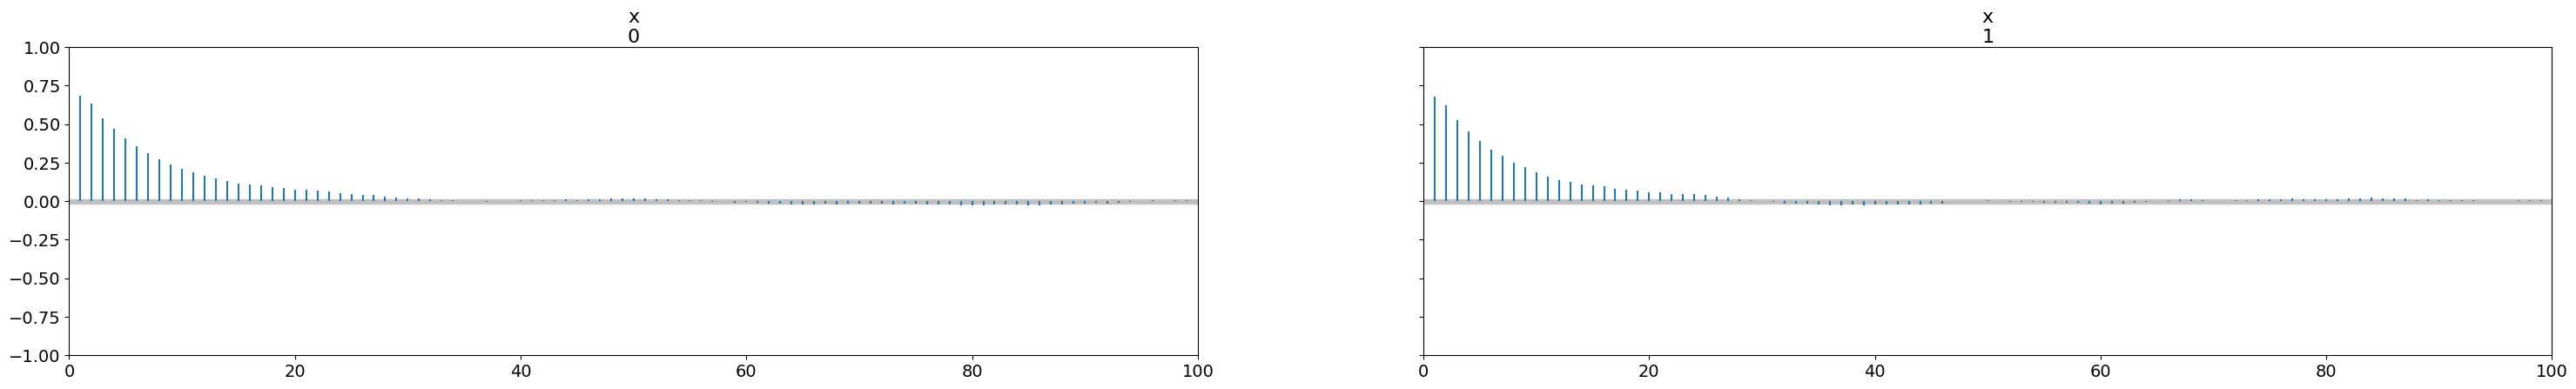

In [36]:
import arviz as az
# with model:
#     idata_pymc3 = az.from_pymc3(
#         trace
#         )

az.plot_autocorr(trace3.posterior.centers.data[:,12500:,0]) #use chain 0

We see that the autocorrelations of our chains 0 for the centers of cluster 0 and cluster 1 are obviously decreasing and hence we can stay positive about the convergence of the chain

## R-hat statistics or Gelman-Rubin test

You may have noticed that sometimes in the progress bar of the Metropolis run there is a warning about the value of R-hat statististics being too high.

Gelman-Rubin test is based on multiple chains and is a ratio of between chain variance to the pooled within chained variances. The closer this value to 1 the better. Values of R-hat satistics higher than 1.2 are considered poor.

In [37]:
print(trace3.posterior.centers.data.shape)
print(az.rhat(trace3.posterior.centers.data[:,12500:,0]))
print(az.rhat(trace3.posterior.centers.data[:,12500:,1]))

(2, 30000, 2)
1.0006468748691273
1.00047058032207


Computing R-hat for centers of our clusters seems relatively close to 1 and therefore we can consider our chain converged (although ideally one would use at least 5 chains)

## MCMC classification problem

Now let us come back to the occupancy data we tackled using Laplace approximation and examine it with the MCMC machinery. We do not have to specify the model all over again, we just need to start Metropolis step within the model context

In [38]:
with first_model:
    step=pm.Metropolis()

    #sample from posterior distribution

    trace=pm.sample(100000, step=step, initvals=start)
    #burned_trace=trace[12500:]

Output()

/usr/local/lib/python3.11/dist-packages/pymc/step_methods/metropolis.py:320: RuntimeWarning: overflow encountered 
in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),

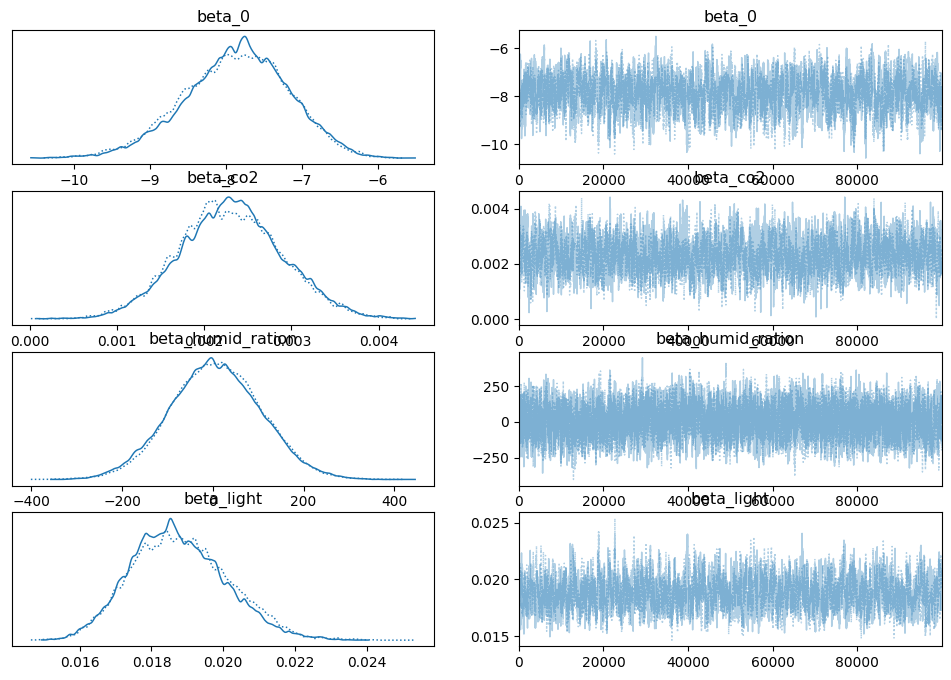

In [39]:
with first_model:
    pm.plot_trace(trace)
    plt.show()
    #odata_pymc3 = az.from_pymc3(
    #    burned_trace
    #    )

Note that distributions obtained for the parameters look very similar to the ones obtained via Laplace approximation. Try using different priors and including more or less variables (one would need to re-initialise the model from the top of the notebook for that). Does the convergence of the chains change a lot? What about R-hat statistics?

In [40]:
az.rhat(trace)

<xarray.Dataset> Size: 32B
Dimensions:            ()
Data variables:
    beta_0             float64 8B 1.003
    beta_co2           float64 8B 1.001
    beta_humid_ration  float64 8B 1.0
    beta_light         float64 8B 1.002